## 🖼 Working with image data in `Meerkat`

*What is `Meerkat`?*  `Meerkat` makes it easier for ML practitioners to interact with high-dimensional, multi-modal data. It provides simple abstractions for data inspection, model evaluation and model training supported by efficient and robust IO under the hood.

**Colab Runtime**: We recommend running this Colab with a GPU runtime. To change the runtime, 
1. Click on `Runtime` on the top navigation bar
2. Select `Change runtime type`
3. Select `GPU` from the dropdown

In [ ]:
!pip install git+https://github.com/robustness-gym/meerkat@dev

  Cloning https://github.com/robustness-gym/meerkat (to revision dev) to /tmp/pip-req-build-vh_pjtuv
  Running command git clone -q https://github.com/robustness-gym/meerkat /tmp/pip-req-build-vh_pjtuv
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
     |████████████████████████████████| 481kB 8.4MB/s 
     |████████████████████████████████| 184kB 34.3MB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
     |████████████████████████████████| 245kB 33.1MB/s 
     |████████████████████████████████| 645kB 33.0MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 245kB 45.4MB/s 
     |████████████████████████████████| 122kB 37.5MB/s 
     |████████████████████████████████| 112kB 44.6MB/s 
  Created wheel for meerkat-ml: filename=meerkat_ml-0.0.2-cp37-none-any.whl size=89297 sha256=95fef8b1d79cc714756a30544ed3cdb4659bde2765b337d

In [ ]:
import os
import meerkat as mk
import numpy as np
# Uncomment the line below to see whats going on under the hood
# logging.getLogger("meerkat").setLevel(logging.INFO)

## 💾 Downloading the data
First, we'll download some data to explore. We're going to use the [Imagenette dataset](https://github.com/fastai/imagenette#image%E7%BD%91), a small subset of the original [ImageNet](https://www.image-net.org/update-mar-11-2021.php).  This dataset is made up of 10 classes (e.g. "garbage truck", "gas pump", "golf ball").
- Download time: <1 minute
- Download size: 130M

In addition to downloading the data, `download_imagnette` prepares a CSV, "imagenette.csv", with a row for each image. 

In [ ]:
from meerkat.contrib.imagenette import download_imagenette

BASE_DIR = "./datasets"
dataset_dir = download_imagenette(BASE_DIR);

  0%|          | 0/99003388 [00:00<?, ?it/s]

Extracting tar archive, this may take a few minutes...


## 📸 Creating an image `DataPanel`
Meerkat's core contribution is the DataPanel, a simple columnar data abstraction. The Meerkat DataPanel can house columns of arbitrary type – from integers and strings to complex, high-dimensional objects like videos, images, medical volumes and graphs.

We're going to build a `DataPanel` out of the "imagenette.csv" file from the download above. 

1. Create a `DataPanel` from a CSV using the `DataPanel.from_csv` class method.
2. Create an `ImageColumn` from the the existing `"img_path"` column using the `DataPanel.from_filepaths` class method and add it to the the `DataPanel`. 

In [ ]:
# 1. Create `DataPanel`
dp = mk.DataPanel.from_csv(os.path.join(dataset_dir, "imagenette.csv"))
# 2. Create `ImageColumn`
dp["img"] = mk.ImageColumn.from_filepaths(filepaths=dp["img_path"])
dp.head()

,img_path (NumpyArrayColumn),label (NumpyArrayColumn),label_id (NumpyArrayColumn),label_idx (NumpyArrayColumn),split (NumpyArrayColumn),index (ListColumn),img (ImageColumn)
0,./datasets/imagenette2-160/train/n02979186/n02...,cassette player,n02979186,482,train,'0',ImagePathCell(n02979186_9036.JPEG)
1,./datasets/imagenette2-160/train/n02979186/n02...,cassette player,n02979186,482,train,'1',ImagePathCell(n02979186_11957.JPEG)
2,./datasets/imagenette2-160/train/n02979186/n02...,cassette player,n02979186,482,train,'2',ImagePathCell(n02979186_9715.JPEG)
3,./datasets/imagenette2-160/train/n02979186/n02...,cassette player,n02979186,482,train,'3',ImagePathCell(n02979186_21736.JPEG)
4,./datasets/imagenette2-160/train/n02979186/ILS...,cassette player,n02979186,482,train,'4',ImagePathCell(ILSVRC2012_val_00046953.JPEG)


The call to `head` shows the first few rows in the `DataPanel`. You can see that there are a few metadata columns, as well as the "img" column we added in.

### 🗂 Indexing.
When we create an `ImageColumn` we don't load the images into memory. Instead, `ImageColumn` keeps track of all those filepaths we passed in and only loads the images when they are accessed. 

Indexing the `ImageColumn` returns an object of type: <class 'PIL.Image.Image'>.


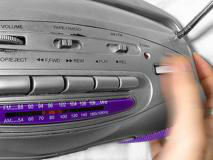

In [ ]:
img = dp["img"][0]
print(f"Indexing the `ImageColumn` returns an object of type: {type(img)}.")
display(img)

We can load a **batch** of images by indexing a slice. Notice that the output is a `ListColumn` of PIL images. 

In [ ]:
img = dp["img"][1:4]
print(f"Indexing a slice of the `ImageColumn` returns a: {type(img)}.")
display(img)

Indexing a slice of the `ImageColumn` returns a: <class 'meerkat.columns.list_column.ListColumn'>.


,(ListColumn)
0,<PIL.Image.Image image mode=RGB size=240x160 a...
1,<PIL.Image.Image image mode=RGB size=160x216 a...
2,<PIL.Image.Image image mode=RGB size=213x160 a...


### 🧫 _Aside_: `ImageColumn` under the hood, `CellColumn`.

If you check out the implementation of `ImageColumn` (at [meerkat/columns/image_column.py](https://github.com/robustness-gym/meerkat/blob/main/mosaic/cells/imagepath.py)), you'll notice that it's a super simple subclass of `CellColumn`. 

_What's a `CellColumn`?_
In `meerkat`, high-dimensional data types like images and videos are typically stored in a `CellColumn`. The advantage of using `CellColumn` (or one of its subclasses) is that we can easily create new column types (e.g. for medical volumes, SpacyDocs, or graphs) without dealing with the implementation complexity of a full column. Instead, we can think in terms of the individual elements in the column: the cells.  We implement a cell by subclassing `AbstractCell` and overriding the `get` method. `get` is called when the cell is accessed, like in the example above. Below is a simple implemenation of an `ImageCell` (the actual cell used by `ImageColumn` is `meerkat.cells.imagepath.ImagePath`, which has a few additional features not included here): 


```python
from meerkat.cells.abstract import AbstractCell
from torchvision.datasets.folder import default_loader

class ImageCell(AbstractCell):

    def __init__(self, filepath: str):
        super(ImagePath, self).__init__()
        self.filepath = filepath

    def get(self, *args, **kwargs):
        return default_loader(self.filepath)
    
    @classmethod
    def _state_keys(cls) -> Collection:
        return {"filepath"}
```
Notice that the `default_loader` isn't called on construction, only on `get`. Additionally, we need to specify the "_state_keys", the set of object attributes needed to recreate the cell. When writing the cell to disk, only these attributes are written. These attributes are typically the bare minimum required to reconstruct the cell.

### 🦥 Lazy indexing.
What if we don't want to load the images? To access the underlying cell (without loading the image), use the lazy indexer, `lz`.

In [ ]:
cell = dp["img"].lz[8000]
print(f"Lazy indexing the `ImageColumn` returns an object of type: {type(cell)}.")
display(cell)

Lazy indexing the `ImageColumn` returns an object of type: <class 'meerkat.cells.imagepath.ImagePath'>.


ImagePathCell(n03445777_18428.JPEG)

Note: **cells can survive on their own.** Everything we need to materialize the cell (e.g. the filepath to the image and the loading function) lives inside the cell, so we can call `cell.get()` to load the image even after the cell has been isolated from its original column. 

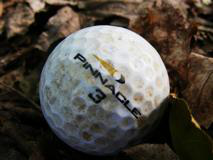

In [ ]:
cell.get()

Using the lazy indexer and one of the following indexing schemes, we can also access a **subset** of a `CellColumn`, which is itself a `CellColumn`.
- **Slice indexing**: _e.g._ `column.lz[4:10]`
- **Integer array indexing**: _e.g._ `column.lz[[0, 4, 6, 11]]`
- **Boolean array indexing**: _e.g._ `column.lz[np.array([True, False, False ..., True, False])]`

In [ ]:
cells = dp["img"].lz[12:16]
print(f"Lazy indexing a slice of the `ImageColumn` returns an object of type: {type(cells)}.")
display(cells)

Lazy indexing a slice of the `ImageColumn` returns an object of type: <class 'meerkat.columns.image_column.ImageColumn'>.


,(ImageColumn)
0,ImagePathCell(n02979186_2733.JPEG)
1,ImagePathCell(n02979186_23069.JPEG)
2,ImagePathCell(n02979186_2467.JPEG)
3,ImagePathCell(n02979186_3293.JPEG)


## 🛠 Applying operations over the DataPanel.

When training and evaluating our models, we often perform operations on each example in our dataset (e.g. compute a model's prediction on each example, tokenize each sentence, compute a model's embedding for each example) and store them. The `DataPanel` makes it easy to perform these operations:  
- Produce new columns (via `DataPanel.map`)
- Produce new columns and store the columns alongside the original data (via `DataPanel.update`)
- Extract an important subset of the datset (via `DataPanel.filter`).   

Under the hood, dataloading is multiprocessed so that costly I/O doesn't bottleneck our computation.

Let's start by filtering the `DataPanel` down to the first 1,000 examples in the validation set. Note that we use the lazy indexer `lz` to avoid loading all of the images. 

In [ ]:
valid_dp = dp.lz[dp["split"].data == "valid"]

### 🫐  Using `DataPanel.map` to compute average intensity of the blue color channel in the images.

To demonstrate the utility `map` operation, we'll explore the relationship between the "blueness" of an image and the class of the image. 

We'll quantify the "blueness" of each image by simply computing the mean intensity of the blue color channel. This can be accomplished with a simple `map` operation over the `DataPanel`:

In [ ]:
blue_col = valid_dp.map(
    lambda x: np.array(x["img"])[:, :, 2].mean(), 
    pbar=True, 
    num_workers=2
)
valid_dp["avg_blue"] = blue_col  # add the intensities as a new column in the `DataPanel` 

  0%|          | 0/3925 [00:00<?, ?it/s]

🪂 vs. ⛳️
Next, we'll explore the relationship between blueness and the class label of the image. To do so, we'll compare the blue intensity distribution of images labeled "parachute" to the distribution of of images labeled "golf ball".
Using the [`seaborn`](https://seaborn.pydata.org/installing.html) plotting package and our `DataPanel`, this can be accomplished in one line: 

In [ ]:
!pip install seaborn

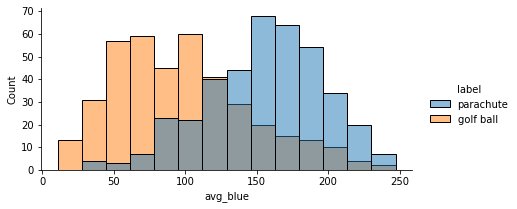

In [ ]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns
plot_dp = valid_dp[np.isin(valid_dp["label"], ["golf ball", "parachute"])]
sns.displot(
    data=plot_dp.to_pandas(), 
    x="avg_blue", 
    hue="label", 
    height=3, 
    aspect=2
);

Looks like images of parachutes are quite a bit more blue than images of golf balls. To understand why this might be the case, we'll take a look at the image with the highest blue intensity:

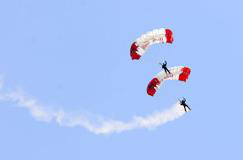

In [ ]:
valid_dp["img"][int(np.argmax(valid_dp["avg_blue"]))]

Photos of parachutes usually have the sky behind them! Checks out that they're so blue...

## 📉 ML with images in `meerkat`.

Let's do some machine learning on our Imagenette `DataPanel`.
We'll take a resnet18 pretrained on the full ImageNet dataset, perform inference on the validation set, and analyze the model's predictions and activations. 

The cell below downloads the model.. 

In [ ]:
import torch
from torchvision.models import resnet18
import torchvision.transforms as transforms
model = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### 💈  Creating an `ImageColumn` with a transform.
In order to do inference, we'll need to create a _new_ `ImageColumn`. The `ImageColumn` we defined above (_i.e._ `"img_path"`), does not apply any transforms after loading and simply returns a PIL image. Before passing the images through the model, we need to convert the PIL image to a `torch.Tensor` and normalize the color channels (along with a few other transformations). 

Note: the transforms defined below are the same as the ones used by torchvision, see [here](https://github.com/pytorch/examples/blob/cbb760d5e50a03df667cdc32a61f75ac28e11cbf/imagenet/main.py#L225). 

In the cell below, we specify a transform when creating the `ImageColumn`.

In [ ]:
# 1. Define transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])

# 2. Create new column with transform 
valid_dp["input"] = mk.ImageColumn.from_filepaths(
    filepaths=valid_dp["img_path"], 
    transform=transform,
)

Notice that indexing this new `ImageColumn` returns a `torch.Tensor`, not a PIL image...  

In [ ]:
img = valid_dp["input"][0]
print(f"Indexing the `ImageColumn` returns an object of type: {type(img)}.")

Indexing the `ImageColumn` returns an object of type: <class 'torch.Tensor'>.


... and that indexing a slice of this new `ImageColumn` returns a `TensorColumn`, not a `ListColumn` of PIL images.

In [ ]:
col = img = valid_dp["input"][:3]
print(f"Indexing a slice of the `ImageColumn` returns an object of type: {type(img)}.")
display(col)

Indexing a slice of the `ImageColumn` returns an object of type: <class 'meerkat.columns.tensor_column.TensorColumn'>.


,(TensorColumn)
0,"torch.Tensor(shape=torch.Size([3, 224, 224]))"
1,"torch.Tensor(shape=torch.Size([3, 224, 224]))"
2,"torch.Tensor(shape=torch.Size([3, 224, 224]))"


Let's see what the full `DataPanel` looks like now.  

In [ ]:
valid_dp.head()

,img_path (NumpyArrayColumn),label (NumpyArrayColumn),label_id (NumpyArrayColumn),label_idx (NumpyArrayColumn),split (NumpyArrayColumn),index (ListColumn),img (ImageColumn),avg_blue (NumpyArrayColumn),input (ImageColumn)
0,./datasets/imagenette2-160/val/n02979186/n0297...,cassette player,n02979186,482,valid,'9469',ImagePathCell(n02979186_8971.JPEG),185.601094,ImagePathCell(n02979186_8971.JPEG)
1,./datasets/imagenette2-160/val/n02979186/n0297...,cassette player,n02979186,482,valid,'9470',ImagePathCell(n02979186_14550.JPEG),62.194748,ImagePathCell(n02979186_14550.JPEG)
2,./datasets/imagenette2-160/val/n02979186/n0297...,cassette player,n02979186,482,valid,'9471',ImagePathCell(n02979186_11971.JPEG),130.162500,ImagePathCell(n02979186_11971.JPEG)
3,./datasets/imagenette2-160/val/n02979186/n0297...,cassette player,n02979186,482,valid,'9472',ImagePathCell(n02979186_11550.JPEG),32.186978,ImagePathCell(n02979186_11550.JPEG)
4,./datasets/imagenette2-160/val/n02979186/n0297...,cassette player,n02979186,482,valid,'9473',ImagePathCell(n02979186_8751.JPEG),57.249444,ImagePathCell(n02979186_8751.JPEG)


### 💫 Computing model predictions and activations.
We'd like to perform inference and extract:
  
1. Output predictions  
2. Output class probabilities  
3. Model activations 

Note: in order to extract model activations, we'll need to use a [PyTorch forward hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) and register it on the final layer of the ResNet. Forward hooks are just functions that get executed on the forward pass of a `torch.nn.Module`. 

In [ ]:
# 1. Define the forward hook
class ActivationExtractor:
    """Extracting activations a targetted intermediate layer"""

    def __init__(self):
        self.activation = None

    def forward_hook(self, module, input, output):
        self.activation = output

# 2. Register the forward hook
extractor = ActivationExtractor()
model.layer4.register_forward_hook(extractor.forward_hook);

We want to apply a forward pass to each image in the `DataPanel` and store the outputs as new columns: `DataPanel.update` is perfectly suited for this task. 

Like `map`, `update` accepts a function and applies it to batches of rows in the the `DataPanel`. Unlike `map`, `update` must return a dictionary. Each key in the dictionary corresponds to a new column that will be added to the updated `DataPanel`. 



In [ ]:
# 1. Move the model to GPU
model.to(0).eval()

# 2. Define a function that runs a forward pass over a batch 
@torch.no_grad()
def predict(batch: mk.DataPanel):
    input_col: mk.TensorColumn = batch["input"] 
    x: torch.Tensor = input_col.data.to(0)  # We get the underlying torch tensor with `data` and move to GPU 
    out: torch.Tensor = model(x)  # Run forward pass

    # Return a dictionary with one key for each of the new columns. Each value in the
    # dictionary should have the same length as the batch. 
    return {
        "pred": out.cpu().numpy().argmax(axis=-1),
        "probs": torch.softmax(out, axis=-1).cpu(),
        "activation": mk.EmbeddingColumn(extractor.activation.mean(dim=[-1,-2]).cpu())
    }
# 3. Apply the update. Note that the `predict` function operates on batches, so we set 
# `batched=True`. Also, the `predict` function only accesses the "input" column, by 
# specifying that here we instruct update to only load that one column and skip others 
valid_dp = valid_dp.update(
    function=predict,
    is_batched_fn=True,
    batch_size=32,
    input_columns=["input"], 
    pbar=True
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/123 [00:00<?, ?it/s]

The predictions, output probabilities, and activations are now stored alongside the examples in the `DataPanel`. 

In [ ]:
valid_dp[["label_id", "input", "pred", "probs", "activation"]].head()

,label_id (NumpyArrayColumn),input (ImageColumn),pred (NumpyArrayColumn),probs (TensorColumn),activation (EmbeddingColumn),index (ListColumn)
0,n02979186,ImagePathCell(n02979186_8971.JPEG),482,torch.Tensor(shape=torch.Size([1000])),torch.Tensor(shape=torch.Size([512])),'9469'
1,n02979186,ImagePathCell(n02979186_14550.JPEG),754,torch.Tensor(shape=torch.Size([1000])),torch.Tensor(shape=torch.Size([512])),'9470'
2,n02979186,ImagePathCell(n02979186_11971.JPEG),482,torch.Tensor(shape=torch.Size([1000])),torch.Tensor(shape=torch.Size([512])),'9471'
3,n02979186,ImagePathCell(n02979186_11550.JPEG),482,torch.Tensor(shape=torch.Size([1000])),torch.Tensor(shape=torch.Size([512])),'9472'
4,n02979186,ImagePathCell(n02979186_8751.JPEG),482,torch.Tensor(shape=torch.Size([1000])),torch.Tensor(shape=torch.Size([512])),'9473'


### 🎯  Computing metrics and analyzing performance. 

Computing statistics on Meerkat `DataPanels` is straightforward because standard NumPy operators and functions can be applied directly to a `NumpyArrayColumn`. We take advantage of this below to compute the accuracy of the model.

In [ ]:
valid_dp["correct"] = valid_dp["pred"] == valid_dp["label_idx"]
accuracy = np.mean(valid_dp["correct"])
print(f"Micro accuracy across the ten Imagenette classes: {accuracy:0.3}")

Micro accuracy across the ten Imagenette classes: 0.672


Furthermore, since the `DataPanel` is naturally converted to a Pandas DataFrame, it's easy to use data visualization tools that interface with Pandas (_e.g._ seaborn, bokeh).

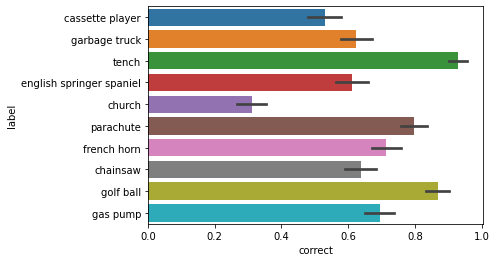

In [ ]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(data=valid_dp.to_pandas(), y="label", x="correct");

### 🔎  Exploring model activations.
To better understand the behavior of our model, we'll explore the activations of the final convolutional layer of the ResNet. Recall that when we performed our forward pass, we extracted these activations and stored them in a new column called `"activation"`.

Unlike the the `NumpyArrayColumn`s we've been working with so far, the activation column has an additional dimension of size 512.

To visualize the activations, we'll use a dimensionality reduction technique ([UMAP](https://umap-learn.readthedocs.io/en/latest/)) to embed the activations in two dimensions. We'll store these embeddings in two new columns "umap_0" and "umap_1". 

In [ ]:
## OPTIONAL: this cell requires the umap dependency: https://umap-learn.readthedocs.io/en/latest/
!pip install umap-learn
from umap import UMAP

# 1. Compute UMAP embedding
reducer = UMAP()
embs = reducer.fit_transform(valid_dp["activation"])

# 2. Add the embedding to the DataPanel as two new columns 
valid_dp["umap_0"] = embs[:, 0]
valid_dp["umap_1"] = embs[:, 1]

     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 1.2MB 42.5MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=ff143b9d4a23bc295b04e236b41163a87fd03a919ce3c167f1652e97251165ac
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51362 sha256=e86fb3b030c4c08cdf374468bbb83dae05505b875d175b554591182619c22ea2
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


Again, we can leverage seaborn to quickly visualize the activations in a 2D scatter plot and color the points by the images label. The activations seem to cluster by the underlying label.  

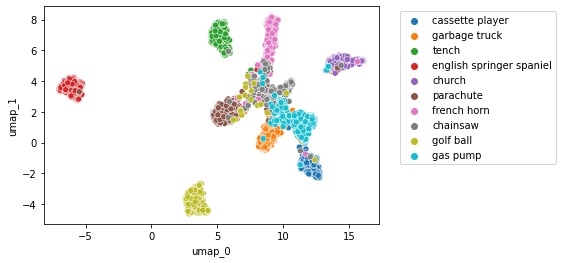

In [ ]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=valid_dp.to_pandas(), x="umap_0", y="umap_1", hue="label");
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## 💾  Writing a `DataPanel` to disk. 
Finally, we can write the updated `DataPanel`, with all the activations and predictions included, to disk for later use.  

`DataPanel` size on disk: 25MB

On disk, the `DataPanel` is stored in a directory at the path passed to `DataPanel.write`. Within that directory, each column is stored separately. This allows us to read only a subset of columns from DataPanel on disk. Use the file explorer to the left to further expore the file structure of the `DataPanel`.  
```
valid_dp
|  +-- meta.yml   
|  +-- state.dill  
|  +-- columns
   |   +-- activation
   |   +-- avg_blue
   |   +-- correct
   |   ...
   |   +-- umap_1
```


In [ ]:
valid_dp.write(os.path.join(dataset_dir, "valid_dp"))

In [ ]:
valid_dp = mk.DataPanel.read(os.path.join(dataset_dir, "valid_dp"))